In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [2]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/uae_data_2022.csv'
output_folder = 'assets/arch'
os.makedirs(output_folder, exist_ok=True)

time_step = 24
num_feats = 5
evaluation_results = []

neurons = 250
epochs = 10
batch_size = 64

In [3]:
# Modified evaluate_model function to store results in evaluation_results



def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()

In [4]:

data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

year = 2022

data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_54458/3722287823.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [5]:
dataset.head()

,Temperature,GHI,Pressure,Wind Speed
Datetime,,,,
2022-04-01 00:30:00,25.0,0,994,1.0
2022-04-01 01:30:00,24.2,0,993,1.3
2022-04-01 02:30:00,23.4,0,993,1.4
2022-04-01 03:30:00,22.8,0,993,1.4
2022-04-01 04:30:00,19.9,0,998,0.5


### BiLSTM

In [6]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

Dimension of train data:  (576, 4)
Dimension of test data:  (144, 4)


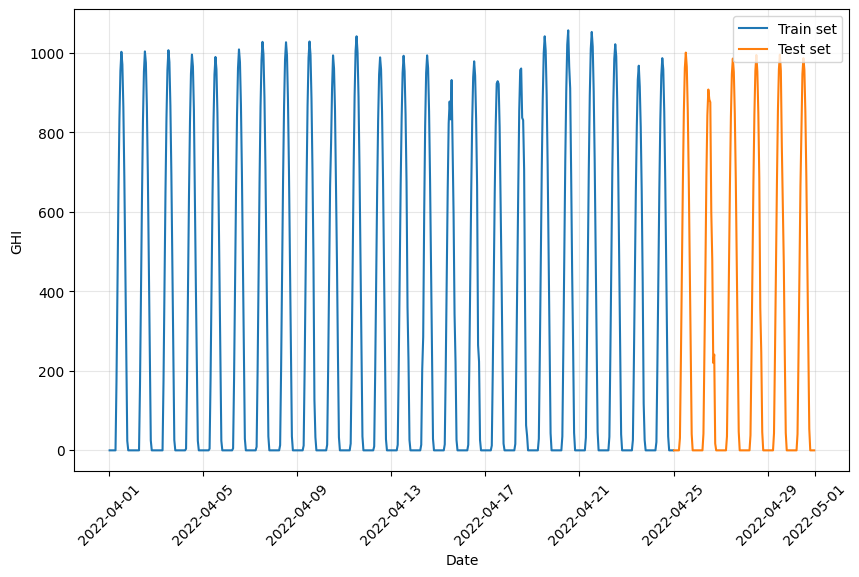

In [7]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.GHI)
plt.plot(test_dataset.GHI)
plt.grid(alpha=0.3)
plt.xlabel('Date')
plt.ylabel('GHI')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xticks(rotation=45)

#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [8]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [9]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_trainy)
output_scaler = scaler_y.fit(y_trainy)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_trainy)
train_x_norm = input_scaler.transform(X_trainy)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_testy)
test_x_norm = input_scaler.transform(X_testy)

In [10]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 24

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (120, 24, 3)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 3)
y_test.shape:  (552, 1)


In [11]:
model = build_bilstm_model(time_step)

In [12]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
9/9 [==============================] - 8s 535ms/step - loss: 0.1475 - val_loss: 0.1016
Epoch 2/10
9/9 [==============================] - 3s 316ms/step - loss: 0.0899 - val_loss: 0.0695
Epoch 3/10
9/9 [==============================] - 3s 364ms/step - loss: 0.0370 - val_loss: 0.0169
Epoch 4/10
9/9 [==============================] - 3s 295ms/step - loss: 0.0177 - val_loss: 0.0153
Epoch 5/10
9/9 [==============================] - 3s 291ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 6/10
9/9 [==============================] - 3s 313ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 7/10
9/9 [==============================] - 3s 392ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 8/10
9/9 [==============================] - 4s 354ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 9/10
9/9 [==============================] - 3s 306ms/step - loss: 0.0059 - val_loss: 0.0103
Epoch 10/10
9/9 [==============================] - 3s 290ms/step - loss: 0.0049 - val_loss: 0.0070


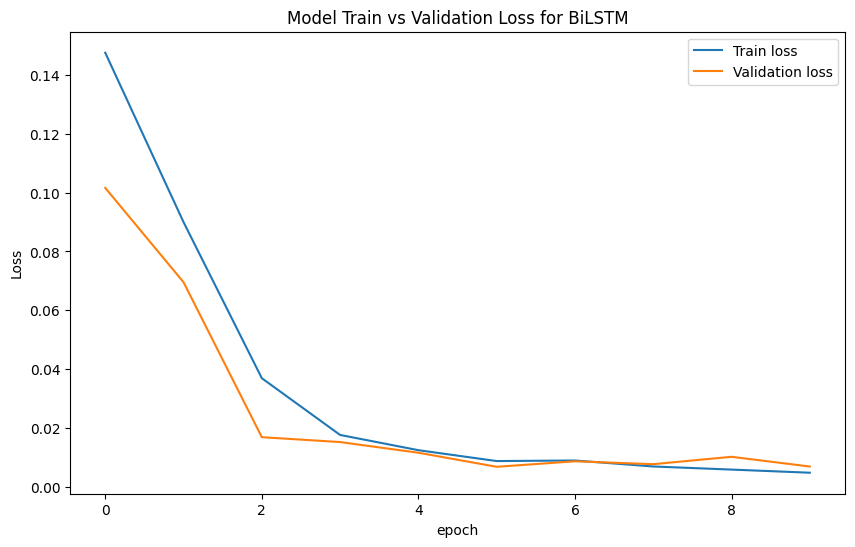

In [13]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'BiLSTM')

In [14]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [15]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 1s 43ms/step


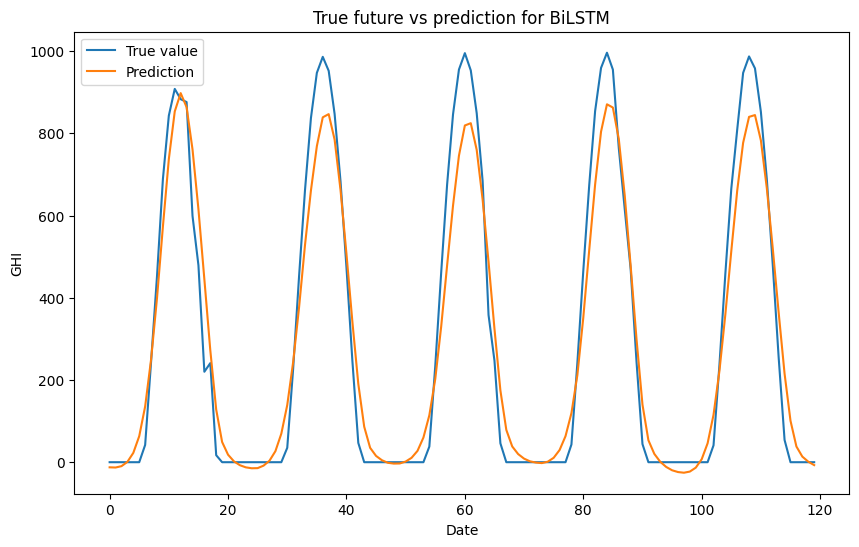

In [16]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)

In [17]:
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

In [18]:
evaluate_model(y_test, prediction_bilstm, 'BiLSTM', 'Testing')

In [19]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,64.80328,7781.330056,88.211848,0.942288


### GBDT-BiLSTM

In [20]:

data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

year = 2022

data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_54458/3722287823.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [21]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]


In [22]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [23]:
# X = dataset.iloc[:, 1:].values  # Features
# y = dataset.iloc[:, 0].values   # Target

# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_trainy, y_trainy)

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_trainy)
gbdt_output_test = gbdt.predict(X_testy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [25]:
input_scaler = MinMaxScaler()
input_scaler.fit(gbdt_output_train.reshape(-1, 1))
output_scaler.fit(gbdt_output_train.reshape(-1, 1))


train_x_norm = input_scaler.transform(gbdt_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))


In [26]:
output_scaler = MinMaxScaler()
output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)


In [27]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (552, 24, 3)
y_train.shape: (552, 1)
X_test.shape: (120, 24, 3)
y_test.shape: (120, 1)


In [28]:
# input_scaler = scaler_x.fit(gbdt_output_train.reshape(-1, 1))
# output_scaler = scaler_y.fit(gbdt_output_test.reshape(-1, 1))

# # Apply the scaler to training data
# # train_y_norm = output_scaler.transform(y_trainy)
# train_x_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))

# # Apply the scaler to test data
# # test_y_norm = output_scaler.transform(y_testy)
# test_y_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))

In [29]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


# TIME_STEPS = 24

# X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


### BiLSTM component

In [30]:
model = build_bilstm_model(time_step)

In [31]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10


9/9 [==============================] - 8s 472ms/step - loss: 0.1277 - val_loss: 0.0630
Epoch 2/10
9/9 [==============================] - 3s 392ms/step - loss: 0.0446 - val_loss: 0.0175
Epoch 3/10
9/9 [==============================] - 3s 302ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 4/10
9/9 [==============================] - 3s 352ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 5/10
9/9 [==============================] - 4s 411ms/step - loss: 0.0054 - val_loss: 0.0111
Epoch 6/10
9/9 [==============================] - 4s 421ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 7/10
9/9 [==============================] - 4s 397ms/step - loss: 0.0046 - val_loss: 0.0118
Epoch 8/10
9/9 [==============================] - 3s 328ms/step - loss: 0.0050 - val_loss: 0.0104
Epoch 9/10
9/9 [==============================] - 3s 383ms/step - loss: 0.0042 - val_loss: 0.0097
Epoch 10/10
9/9 [==============================] - 3s 320ms/step - loss: 0.0036 - val_loss: 0.0106


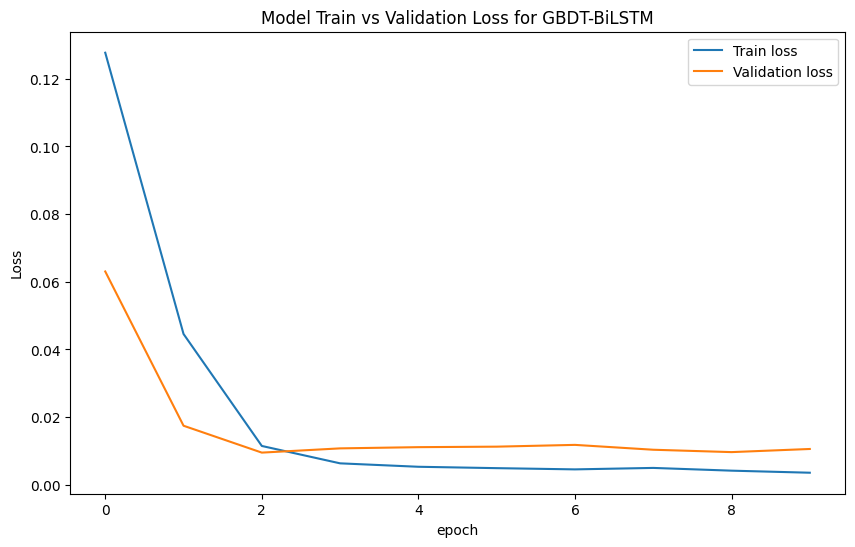

In [32]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'GBDT-BiLSTM')

In [33]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [34]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 1s 39ms/step


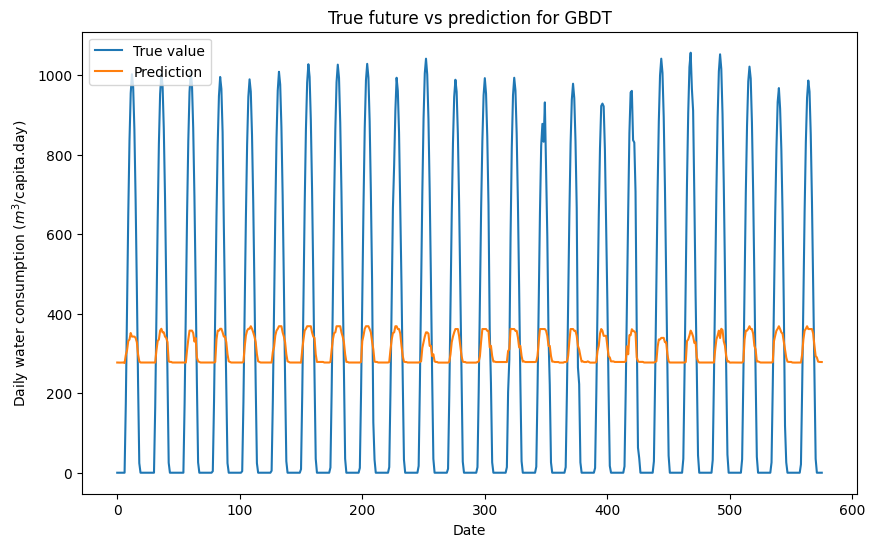

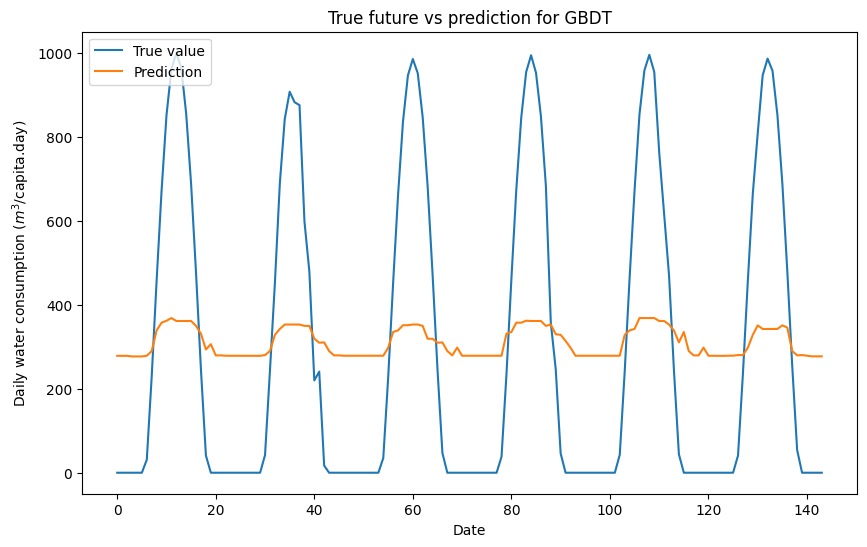

In [35]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(gbdt_output_train, 'GBDT', y_trainy)
plot_future(gbdt_output_test, 'GBDT', y_testy)

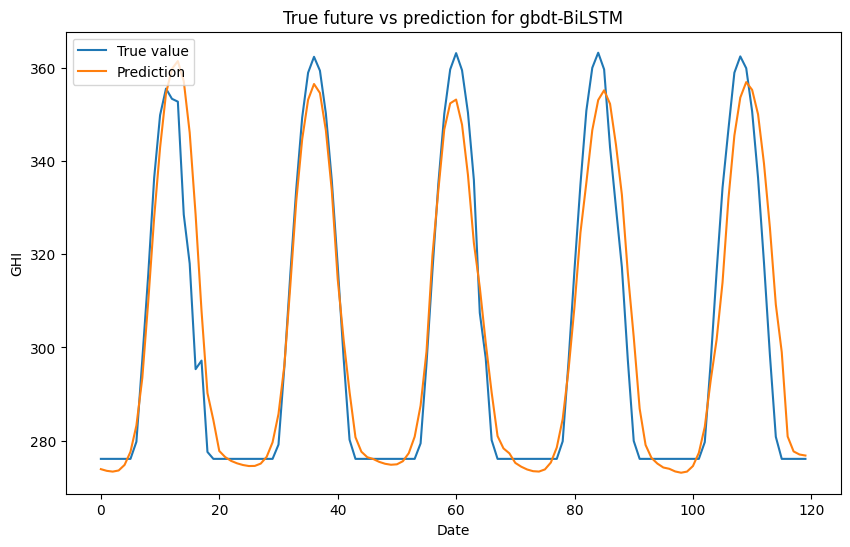

In [36]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'gbdt-BiLSTM', y_test)

In [37]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, gbdt_output_train, 'CatBoost', 'Training')
evaluate_model(y_testy, gbdt_output_test, 'CatBoost', 'Testing')

In [38]:
# Evaluate model performance on training and test sets
evaluate_model(y_test, prediction_bilstm, 'GBDT-BiLSTM', 'Testing')
# evaluate_model(y_testy, gbdt_output_test, 'GBDT', 'Testing')

In [39]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'GBDT-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
3,GBDT-BiLSTM,Testing,6.41131,90.906373,9.534483,0.912087


In [40]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'GBDT-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
3,GBDT-BiLSTM,Testing,6.41131,90.906373,9.534483,0.912087


## catboost-bilstm

In [41]:

data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

year = 2022

data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_54458/3722287823.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [42]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [43]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [44]:
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_trainy, y_trainy)

0:	learn: 379.7202265	total: 60.5ms	remaining: 5.99s
1:	learn: 379.4362961	total: 61ms	remaining: 2.99s
2:	learn: 379.1348161	total: 61.3ms	remaining: 1.98s
3:	learn: 378.8478492	total: 61.5ms	remaining: 1.48s
4:	learn: 378.5748323	total: 61.8ms	remaining: 1.17s
5:	learn: 378.3058702	total: 62ms	remaining: 972ms
6:	learn: 378.0202450	total: 62.3ms	remaining: 827ms
7:	learn: 377.7531898	total: 62.4ms	remaining: 717ms
8:	learn: 377.5001595	total: 62.6ms	remaining: 633ms
9:	learn: 377.2216068	total: 62.9ms	remaining: 566ms
10:	learn: 376.9292195	total: 63.1ms	remaining: 511ms
11:	learn: 376.6367270	total: 63.3ms	remaining: 464ms
12:	learn: 376.3518781	total: 63.6ms	remaining: 426ms
13:	learn: 376.0613950	total: 63.9ms	remaining: 392ms
14:	learn: 375.7885685	total: 64.1ms	remaining: 363ms
15:	learn: 375.5029861	total: 64.4ms	remaining: 338ms
16:	learn: 375.2184136	total: 64.7ms	remaining: 316ms
17:	learn: 374.9456930	total: 65ms	remaining: 296ms
18:	learn: 374.6655948	total: 65.3ms	remaini

In [45]:
catboost_output_train = catboost.predict(X_trainy)
catboost_output_test = catboost.predict(X_testy)

In [46]:
input_scaler = MinMaxScaler()
input_scaler.fit(catboost_output_train.reshape(-1, 1))
output_scaler.fit(catboost_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(catboost_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(catboost_output_test.reshape(-1, 1))


In [47]:
output_scaler = MinMaxScaler()
output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [48]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


BiLSTM component

In [49]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
9/9 [==============================] - 5s 373ms/step - loss: 0.1187 - val_loss: 0.0531
Epoch 2/10
9/9 [==============================] - 3s 311ms/step - loss: 0.0323 - val_loss: 0.0320
Epoch 3/10
9/9 [==============================] - 5s 590ms/step - loss: 0.0106 - val_loss: 0.0124
Epoch 4/10
9/9 [==============================] - 4s 381ms/step - loss: 0.0075 - val_loss: 0.0173
Epoch 5/10
9/9 [==============================] - 3s 312ms/step - loss: 0.0061 - val_loss: 0.0080
Epoch 6/10
9/9 [==============================] - 3s 350ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 7/10
9/9 [==============================] - 4s 402ms/step - loss: 0.0053 - val_loss: 0.0070
Epoch 8/10
9/9 [==============================] - 3s 314ms/step - loss: 0.0050 - val_loss: 0.0093
Epoch 9/10
9/9 [==============================] - 2s 263ms/step - loss: 0.0041 - val_loss: 0.0111
Epoch 10/10
9/9 [==============================] - 2s 257ms/step - loss: 0.0038 - val_loss: 0.0060


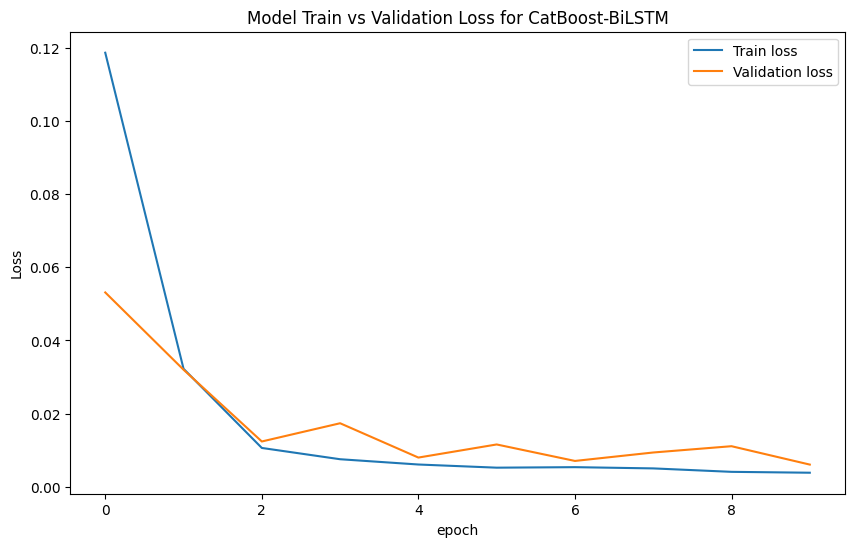

In [50]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'CatBoost-BiLSTM')

In [51]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [52]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 0s 28ms/step


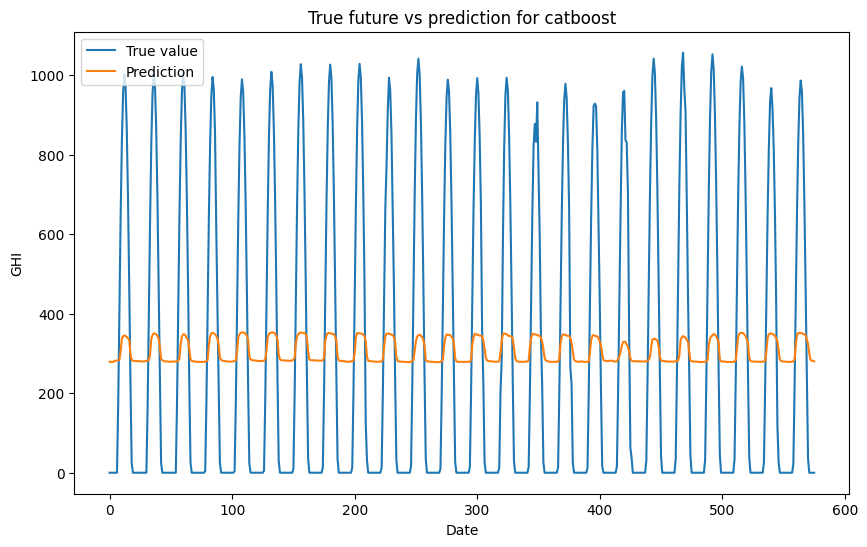

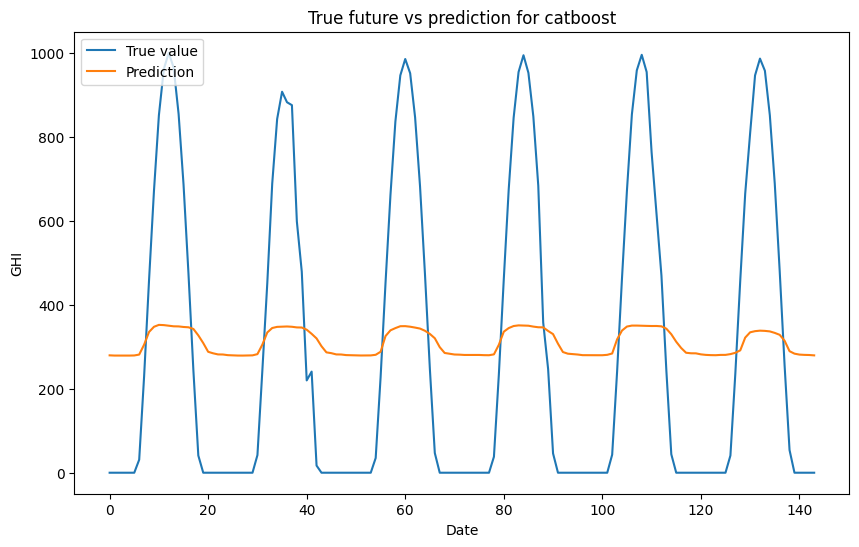

In [53]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(catboost_output_train, 'catboost', y_trainy)
plot_future(catboost_output_test, 'catboost', y_testy)

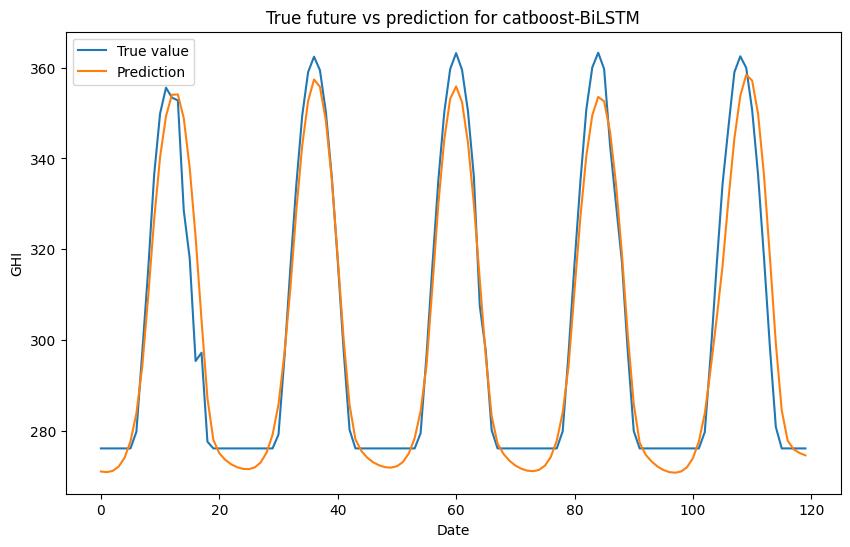

In [54]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'catboost-BiLSTM', y_test)

In [55]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, catboost_output_train, 'CatBoost', 'Training')
evaluate_model(y_testy, catboost_output_test, 'CatBoost', 'Testing')

In [56]:
evaluate_model(y_test, prediction_bilstm, 'CatBoost-BiLSTM', 'Testing')


In [57]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'CatBoost-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
6,CatBoost-BiLSTM,Testing,5.380128,51.736237,7.192791,0.949968


## xgb-bilstm

In [58]:

data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

year = 2022

data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_54458/3722287823.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [59]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [60]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [61]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_trainy, y_trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
xgb_output_train = xgb.predict(X_trainy)
xgb_output_test = xgb.predict(X_testy)

In [63]:
input_scaler = MinMaxScaler()
input_scaler.fit(xgb_output_train.reshape(-1, 1))
output_scaler.fit(xgb_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(xgb_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(xgb_output_test.reshape(-1, 1))


In [64]:
output_scaler = MinMaxScaler()
output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [65]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [66]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
9/9 [==============================] - 5s 333ms/step - loss: 0.1133 - val_loss: 0.0414
Epoch 2/10
9/9 [==============================] - 3s 353ms/step - loss: 0.0269 - val_loss: 0.0308
Epoch 3/10
9/9 [==============================] - 3s 318ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 4/10
9/9 [==============================] - 3s 331ms/step - loss: 0.0084 - val_loss: 0.0167
Epoch 5/10
9/9 [==============================] - 3s 325ms/step - loss: 0.0065 - val_loss: 0.0123
Epoch 6/10
9/9 [==============================] - 3s 352ms/step - loss: 0.0057 - val_loss: 0.0150
Epoch 7/10
9/9 [==============================] - 4s 396ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 8/10
9/9 [==============================] - 2s 269ms/step - loss: 0.0058 - val_loss: 0.0142
Epoch 9/10
9/9 [==============================] - 2s 262ms/step - loss: 0.0047 - val_loss: 0.0115
Epoch 10/10
9/9 [==============================] - 3s 304ms/step - loss: 0.0047 - val_loss: 0.0110


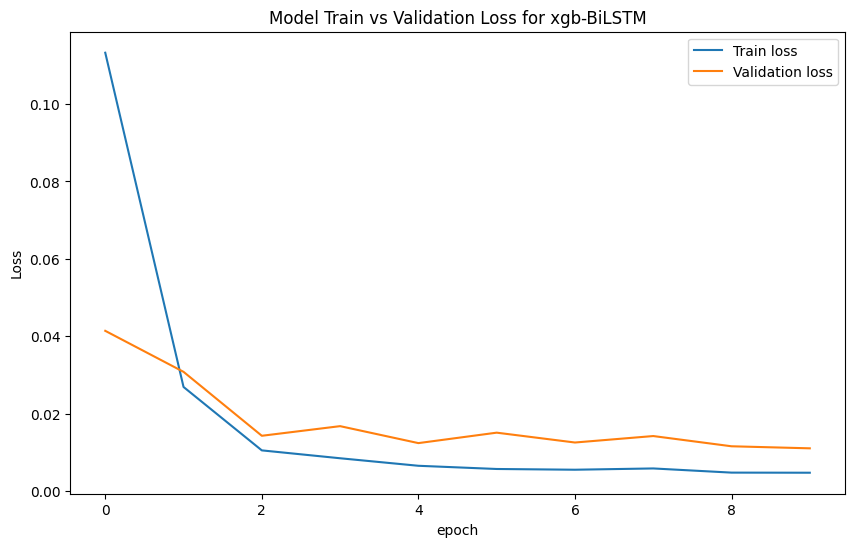

In [67]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'xgb-BiLSTM')

In [68]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [69]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 0s 26ms/step


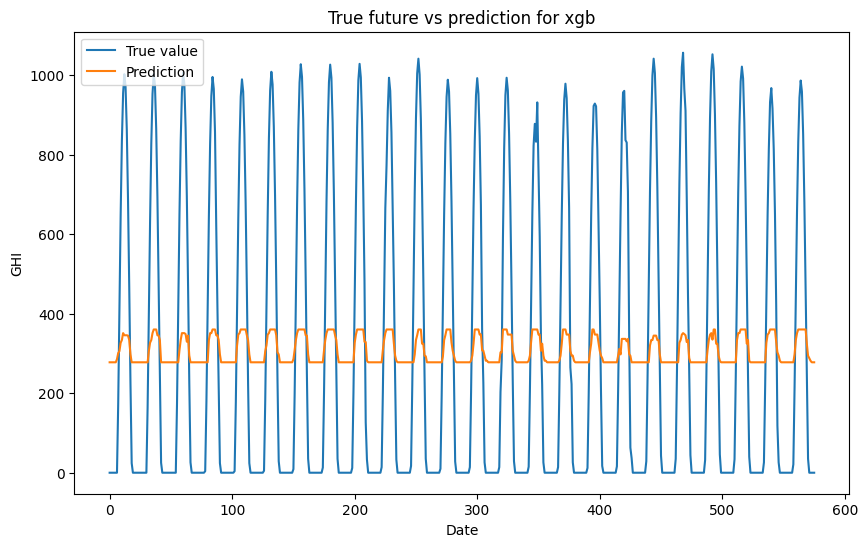

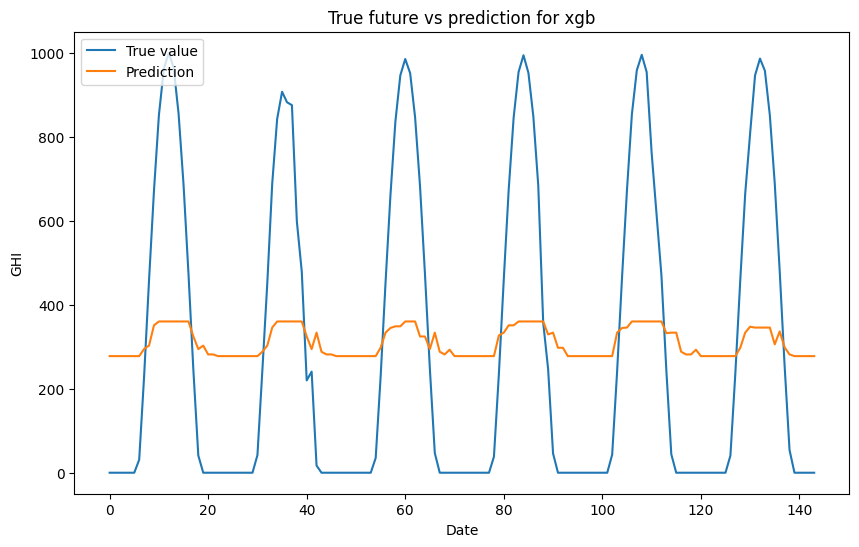

In [70]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(xgb_output_train, 'xgb', y_trainy)
plot_future(xgb_output_test, 'xgb', y_testy)

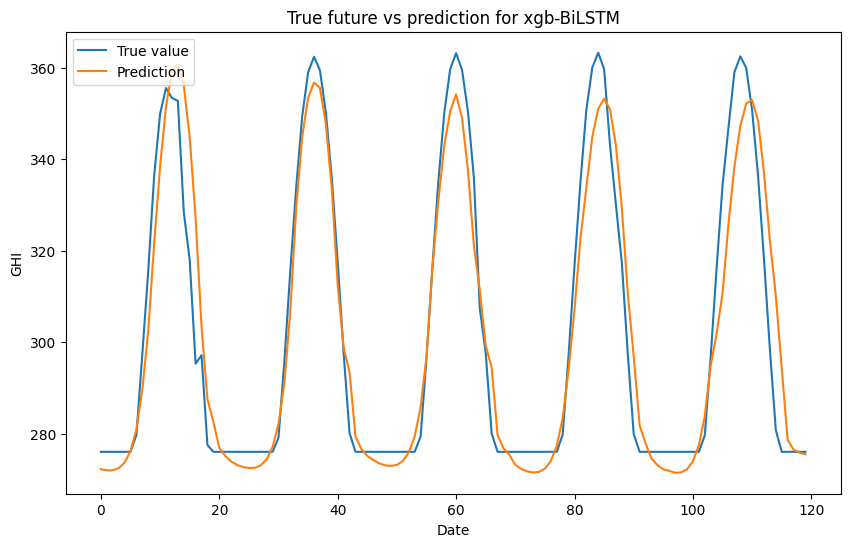

In [71]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'xgb-BiLSTM', y_test)

In [72]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, xgb_output_train, 'xgb', 'Training')
evaluate_model(y_testy, xgb_output_test, 'xgb', 'Testing')

In [73]:
evaluate_model(y_test, prediction_bilstm, 'xgb-BiLSTM', 'Testing')


In [74]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'xgb-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
9,xgb-BiLSTM,Testing,6.896103,94.236533,9.70755,0.908867


## lightgbm-bilstm

In [75]:

data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])

year = 2022

data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_54458/3722287823.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [76]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [77]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [78]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)
lgbm.fit(X_trainy, y_trainy)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 3
[LightGBM] [Info] Start training from score 305.125000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMRegressor(learning_rate=0.001, max_depth=5)

In [79]:
lgbm_output_train = lgbm.predict(X_trainy)
lgbm_output_test = lgbm.predict(X_testy)

In [80]:
input_scaler = MinMaxScaler()
input_scaler.fit(lgbm_output_train.reshape(-1, 1))
output_scaler.fit(lgbm_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(lgbm_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(lgbm_output_test.reshape(-1, 1))


In [81]:
output_scaler = MinMaxScaler()
output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [82]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [83]:
model = build_bilstm_model(time_step)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
9/9 [==============================] - 6s 373ms/step - loss: 0.1287 - val_loss: 0.0686
Epoch 2/10
9/9 [==============================] - 3s 337ms/step - loss: 0.0478 - val_loss: 0.0129
Epoch 3/10
9/9 [==============================] - 3s 302ms/step - loss: 0.0154 - val_loss: 0.0099
Epoch 4/10
9/9 [==============================] - 3s 297ms/step - loss: 0.0099 - val_loss: 0.0086
Epoch 5/10
9/9 [==============================] - 3s 295ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 6/10
9/9 [==============================] - 3s 288ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 7/10
9/9 [==============================] - 3s 365ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 8/10
9/9 [==============================] - 3s 301ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 9/10
9/9 [==============================] - 3s 372ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 10/10
9/9 [==============================] - 3s 322ms/step - loss: 0.0047 - val_loss: 0.0073


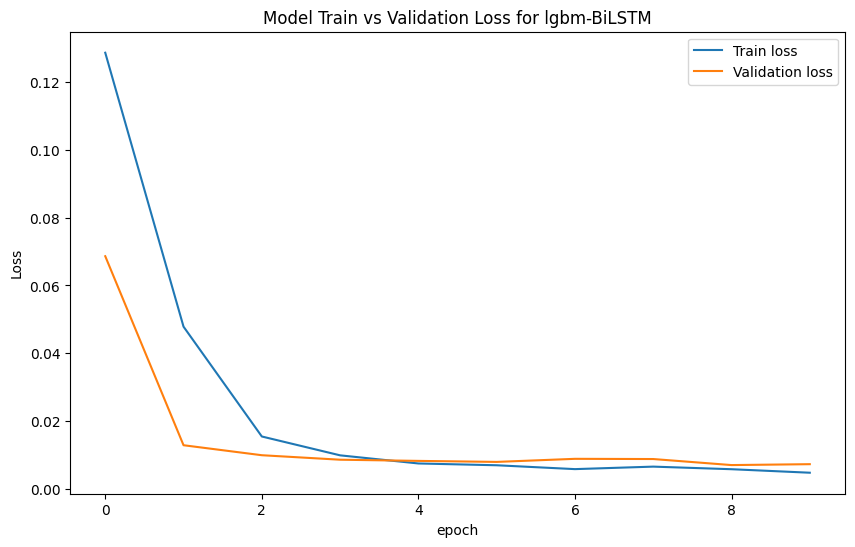

In [84]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history, 'lgbm-BiLSTM')

In [85]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [86]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model)

4/4 [==============================] - 0s 25ms/step


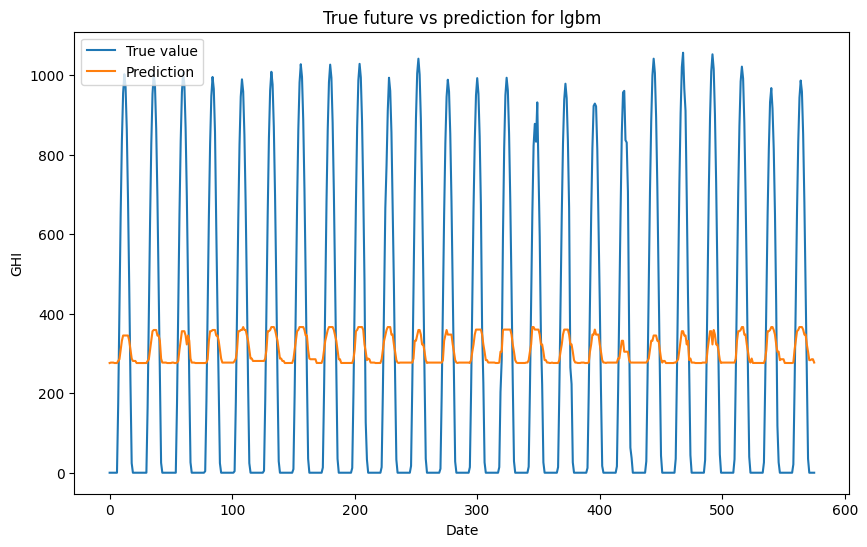

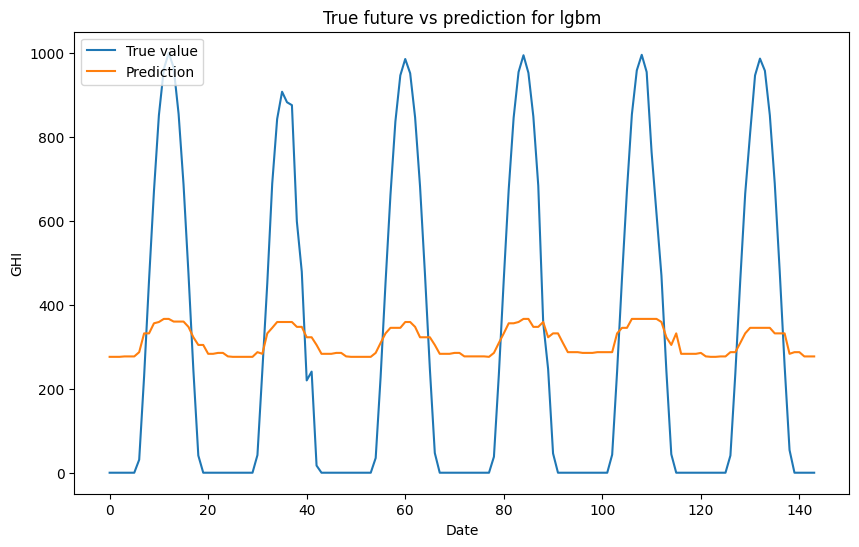

In [87]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(lgbm_output_train, 'lgbm', y_trainy)
plot_future(lgbm_output_test, 'lgbm', y_testy)

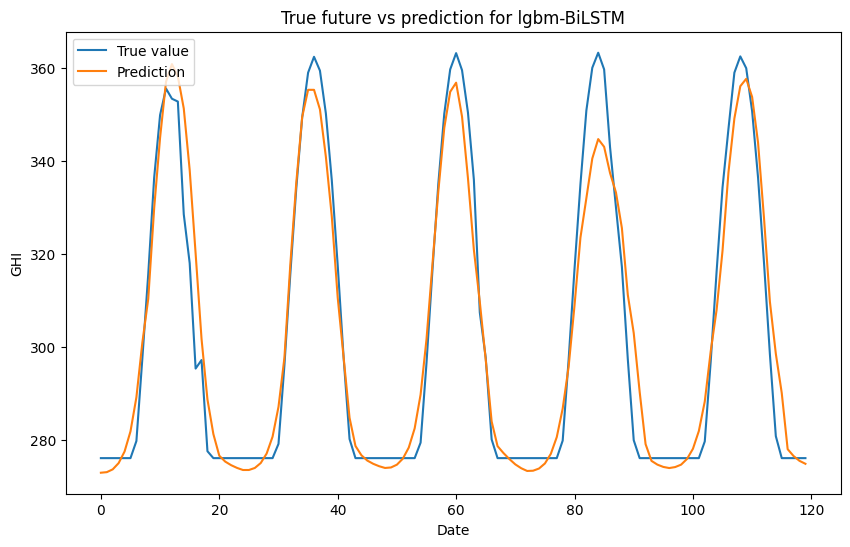

In [88]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'lgbm-BiLSTM', y_test)

In [89]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, lgbm_output_train, 'lgbm', 'Training')
evaluate_model(y_testy, lgbm_output_test, 'lgbm', 'Testing')

In [90]:
evaluate_model(y_test, prediction_bilstm, 'lgbm-BiLSTM', 'Testing')

In [91]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'lgbm-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
12,lgbm-BiLSTM,Testing,5.565736,62.277492,7.891609,0.939773


### Results

In [92]:
def highlight_bilstm_rows(row):
  if 'BiLSTM' in row['Model']:
    return ['background-color: rgba(255, 255, 0, 0.4)'] * len(row)
  else:
    return [''] * len(row)

In [93]:
results_df = pd.DataFrame(evaluation_results)
styled_results_df = results_df.style.apply(highlight_bilstm_rows, axis=1)
print("\nevaluation metrics table: ")
styled_results_df


evaluation metrics table: 


,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,64.803280,7781.330056,88.211848,0.942288
1,CatBoost,Training,312.822774,120818.662666,347.589791,0.163320
2,CatBoost,Testing,304.762540,114693.014751,338.663572,0.159306
3,GBDT-BiLSTM,Testing,6.411310,90.906373,9.534483,0.912087
4,CatBoost,Training,317.699716,124760.060548,353.213902,0.136026
5,CatBoost,Testing,309.399978,117988.725798,343.494870,0.135149
6,CatBoost-BiLSTM,Testing,5.380128,51.736237,7.192791,0.949968
7,xgb,Training,313.481976,121540.809596,348.627035,0.158319
8,xgb,Testing,305.014450,114906.261380,338.978261,0.157743
9,xgb-BiLSTM,Testing,6.896103,94.236533,9.707550,0.908867
